# Trajectory analysis notebook
In this notebook we show how the MDAnalysis package can be used to perform some _basic_ analysis of the simulations using the atomic trajectory generated by openMM (or any other MD package).

In [1]:
# Packages for the trajectory analysis and visualisation
import MDAnalysis as md
import nglview as ng

# python packages
import pandas as pd                  # Dataframes and reading CSV files
import numpy as np                   # Numerical libraries
import matplotlib.pyplot as plt      # Plotting library
from lmfit import Model              # Least squares fitting library
from scipy.optimize import curve_fit # Alternative curve fittting library

For simplicity we define three variables that represent the three Cartesian directions. 

In [2]:
X = 0
Y = 1
Z = 2

First of all we have to load the trajectory. In this case the trajectory was written in the _CHARMM_ DCD format, which is binary (not ASCII) _i.e._ not human-readable, which is done to save storage space. Indeed classical MD simulations can generate very large trajectories, and storage can become an issue. Moreover, the DCD file contains only the coordinates and no information about the atoms' type. Hence, we have to use an auxiliary file to retrieve that info, in this case the PDB files. This approach is also normal to many visualisation tools.

In [3]:
sys = md.Universe("mix.pdb", 'trajectory.1.dcd')
# md.topology.guessers.guess_atom_element("Ar")
nFrames = len(sys.trajectory)
print("Number of Frames : %4i" % nFrames)

Number of Frames :   20


With MDAnalysis it is very easy to select a group of atoms, which can then be used to for the analysis.

In [4]:
atoms = sys.select_atoms("all")
numberOfAtoms = len(atoms.positions)
print(" Number of Atoms : %4i" % numberOfAtoms)

 Number of Atoms : 4096


Although we don't need the have the atomic charges for our analysis, we need to define them this to avoid errors later

In [5]:
sys.add_TopologyAttr('charge', [0]*numberOfAtoms)

It is then easy to access information frame by frame by looping over the _system trajectory_ object. For example we can print the cell dimensions and the coordinates of the first atom.

In [6]:
for iFrame in sys.trajectory:
    boxSize = np.array(sys.dimensions[0:3])
    print("Frame : %2i" % iFrame.frame)
    print("Cell dimensions [Angstroms]       : %8.3f %8.3f %8.3f" % 
        (boxSize[X],boxSize[Y],boxSize[Z]) )
    print("Coordinates of atom 1 [Angstroms] : %8.3f %8.3f %8.3f" % 
         (atoms.positions[0,X],atoms.positions[0,Y],atoms.positions[0,Z]) )
    print("---")
    if iFrame.frame == 2: break

Frame :  0
Cell dimensions [Angstroms]       :   46.917   46.917   93.833
Coordinates of atom 1 [Angstroms] :   37.113    9.679   33.534
---
Frame :  1
Cell dimensions [Angstroms]       :   46.889   46.889   93.777
Coordinates of atom 1 [Angstroms] :   37.462    9.721   33.356
---
Frame :  2
Cell dimensions [Angstroms]       :   46.837   46.837   93.673
Coordinates of atom 1 [Angstroms] :   37.502    9.570   33.403
---


We can then visualise the trajectory using nglview, which can directly read the MDAnalysis _system_.

In [7]:
view = ng.show_mdanalysis(sys, gui=True)
view.center()
view.representations = [
    {"type": "spacefill", "params": {"sele": "all"}},
    {"type": "unitcell", "params": {"sele": "all"}}
]
view.camera = 'orthographic'
view

NGLWidget(max_frame=19)

The first analysis we can do is to look at the radial pair distribution function.

\begin{equation}
g(r) =  \Bigg\langle \frac{\sum_{i\lt j} \delta(r_{ij}-r_0)}{4\pi r^2\rho} \Bigg\rangle
\end{equation}

where 
$\langle\rangle$ indicates the average over the frames of the MD simulation,
$\rho$ is the number density of an homogeneous fluid with the same density of the system
and $\delta$ is the Kroneker delta function

\begin{equation}
\delta(r_{ij}-r_0) = \begin{cases}
0 &\text{if } r_{ij} \ne r_0,   \\
1 &\text{if } r_{ij} = r_0   
\end{cases}
\end{equation}

  0%|          | 0/20 [00:00<?, ?it/s]

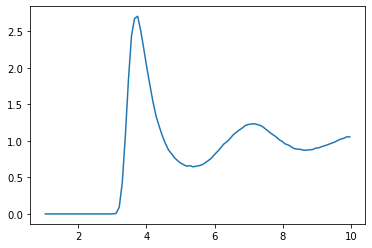

In [8]:
from MDAnalysis.analysis import rdf

rdf = rdf.InterRDF(atoms, atoms, range=(1,10), nbins=100)

rdf.run(verbose=True)
plt.plot(rdf.results.bins, rdf.results.rdf)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

234 234 469


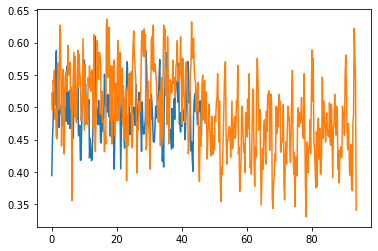

In [9]:
from MDAnalysis.analysis import lineardensity
ldens = lineardensity.LinearDensity(atoms,binsize=.2,verbose=True)
dmap = ldens.run()

x = list(np.arange(0,dmap.dimensions[X],dmap.binsize))
y = list(np.arange(0,dmap.dimensions[Y],dmap.binsize))
z = list(np.arange(0,dmap.dimensions[Z],dmap.binsize))

nx = len(x)-1
ny = len(y)-1
nz = len(z)-1

print(nx,ny,nz)
fig = plt.figure()
ax = fig.gca()

ax.plot(x[0:nx],dmap.results.x.pos[0:nx])
ax.plot(z[0:nz],dmap.results.z.pos[0:nz])

plt.show()

Alternatively, we could compute the atoms' density manually by looping over the frames and use the Numpy histogram function.

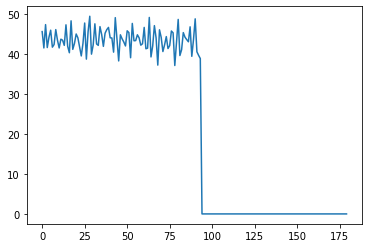

In [10]:
histo = np.zeros(180, dtype=float)
for iFrame in sys.trajectory:
    y, x = np.histogram(atoms.positions[:,Z], bins=180, range=(0.,180.))
    histo[:] = histo[:] + y
histo /= nFrames

fig = plt.figure()
ax = fig.gca()
ax.plot(x[0:-1],histo)
plt.show()